# Implementation for Task1

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from typing import Callable

We solve the diffusion-reaction equation

$$
u_t = \mu u_xx + a u
$$

where $\mu$ is a positive constant and $a$ is a constant.

The domain is $(x, t) \in [0, 1] \times [0, T]$, where $T$ is the end point in time.
Boundary conditions are given by functions $f, g_1$ and $g_2$:

\begin{align*}
u(0, x) &= f(x) \\
u(t, 0) &= g_1(t) \\
u(t, 1) &= g_2(t)
\end{align*}

The following class implements a solver based on the discretization in the project description.

In [3]:
class ReacDiffSolver:
    """Solving the linear diffusion-reaction equation

    u_t = mu u_xx + a u

using a modified Crank Nicholson scheme on the domain
0 <= x <= 1, 0 <= t <= T, with boundary conditions
u(0, x) = f(x), u(t, 0) = g1(t), u(t, 1) = g2(t).
    """
    alpha = 1   # U* = U(n + alpha*k)

    def __init__(self, mu: float, a: float, f: Callable, g1: Callable, g2: Callable) -> None:
        self.mu = mu
        self.a = a
        self.f = f
        self.g1 = g1
        self.g2 = g2

    def solve(self, M: int, N: int, T: int=1) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """M: number of inner grid points in space.
        N: number of steps in time.
        T: end time

        returns:
            array of size (N+1, M+2)
            array with points in space (M+2)
            array with points in time (N+1)
        """
        k = 1/N                 # step size in time
        h = 1/(M + 1)           # step size in space
        r = self.mu * k / h**2

        sol = np.zeros((N + 1, M+2))
        x = np.linspace(0, 1, M + 2)
        t = np.linspace(0, 1, N + 1)

        # set boundaries
        sol[0, :] = self.f(x)
        sol[1:, 0] = self.g1(t[1:])
        sol[1:, -1] = self.g2(t[1:])

        # construct the lhs of the system: A U* = b
        A = sp.sparse.diags(
            [-r/2, 1 + r, -r/2],
            offsets=[-1, 0, 1],
            shape=(M, M)
        ).tocsr()

        for n in range(N):
            Unm1 = sol[n, :-2]  # U_{n-1}
            Un = sol[n, 1:-1]   # U_{n}
            Unp1 = sol[n, 2:]   # U_{n+1}

            # solve equation for U* (implicit step)
            b = (1 + k*self.a)*Un + r/2*(Unm1 - 2*Un + Unp1)
            Ustar = sp.sparse.linalg.spsolve(A, b)

            # do a step forward in time (explicit step)
            sol[n + 1, 1:-1] = Ustar + k/2*(self.a*Ustar - self.a*Un)

        return sol, x, t

Let's run it on a test problem.
We set $\mu = 1/5, a = 5$, and boundary conditions
\begin{align*}
u(0, x) &= \sin(2\pi x) \\
u(t, 0) &= 0 \\
u(t, 1) &= 0
\end{align*}

The analytic solution is 
$$
u(t, x) = \text{e}^{-(4\pi^2 \mu - a)t}\sin(2\pi x)
$$

In [4]:
def anal(t, x, mu, a):
    return np.exp(-(4*np.pi**2*mu - a)*t)*np.sin(2*np.pi*x)

def plot3d(x, t, sol):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # X, Y = np.meshgrid(x, t)
    ax.plot_surface(*np.meshgrid(x, t), sol)

    ax.set_xlabel('x')
    ax.set_ylabel('t')

    plt.show()

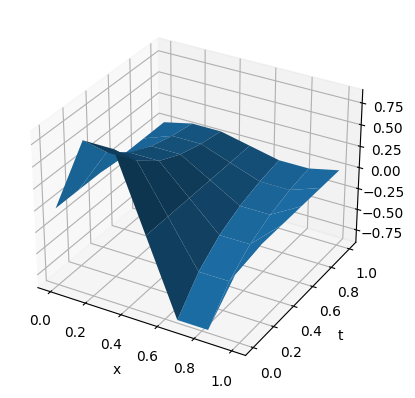

In [5]:
solver = ReacDiffSolver(
    mu=0.2,
    a=5,
    f=lambda x: np.sin(2*np.pi*x),
    g1=lambda t: 0*t,
    g2=lambda t: 0*t
)
sol, x, t = solver.solve(M=5, N=5)
plot3d(x, t, sol)

Let's take a look at the error.
We plot max error in space as a function of time:
$$
E^n = \max_m |e_m^n|
$$

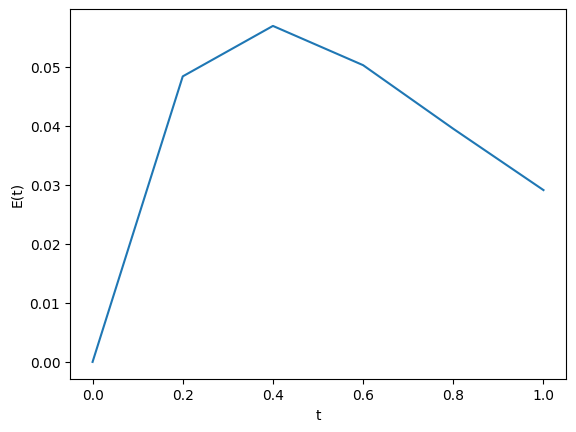

In [6]:
errs = np.zeros_like(t)
for i, _t in enumerate(t):
    _anal = anal(_t, x, mu=0.2, a=5)
    errs[i] = np.linalg.norm(_anal - sol[i], ord=np.inf)

fig, ax = plt.subplots()
ax.plot(t, errs)
ax.set(ylabel="E(t)", xlabel="t")
plt.show()

Let's try to take max norm over both space and time, and let $h \to 0$ whilst fixating $k$.

In [7]:
Ns = np.logspace(1, 3, 3, dtype=int)
Ms = np.logspace(1, 5, 5, dtype=int)
errs = np.zeros((Ns.size, Ms.size), dtype=float)

solver = ReacDiffSolver(
    mu=0.2,
    a=5,
    f=lambda x: np.sin(2*np.pi*x),
    g1=lambda t: 0*t,
    g2=lambda t: 0*t
)

for k, _N in enumerate(Ns):
    for i, _M in enumerate(Ms):
        sol, x, t = solver.solve(M=_M, N=_N)
        _anal = np.zeros_like(sol)
        
        for j, _t in enumerate(t):
            _anal[j, :] = anal(_t, x, mu=0.2, a=5)

        errs[k, i] = np.max(np.abs(sol - _anal))

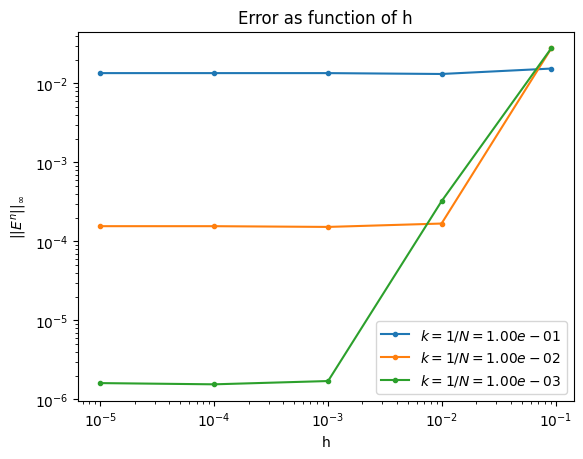

In [8]:
fig, ax = plt.subplots()
for i, _N in enumerate(Ns):
    ax.loglog(1/(Ms + 1), errs[i], '.-', label=f"$k = 1/N = {1/_N:.2e}$")
ax.set(xlabel="h", ylabel=r"$||E^n||_\infty$", title="Error as function of h")
ax.legend()
plt.show()